# ism3d.arts/.simxy/.simuv: modeling in the image/visibility-domain

## Setup

We first import essential API functions / modules from `ism3d` and other libraries

**Used ISM3D Functions:**

* `im3d.logger.logger_config`
* `im3d.logger.logger_status`

In [63]:
nb_dir=_dh[0]
os.chdir(nb_dir+'/../output/mockup')
sys.path.append(nb_dir)
from notebook_setup import *

%matplotlib inline
#%config InlineBackend.figure_format = "png" #  ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%reload_ext wurlitzer
%reload_ext memory_profiler
%reload_ext line_profiler

#ism3d.logger_config(logfile='ism3d.log',loglevel='INFO',logfilelevel='INFO',log2term=False)
ism3d.logger_config(logfile='ism3d.log',loglevel='DEBUG',logfilelevel='DEBUG',log2term=False)

print(''+ism3d.__version__)
print('working dir: {}\n'.format(os.getcwd()))

0.3.dev1
working dir: /Users/Rui/Resilio/Workspace/projects/ism3d/models/output/mockup



## Data Import 

We import the visibility data from CASA measurement sets into the internal `uvdata` variable (essential a simple nested dict, not class yet) and also save them into compressed HDF5 for compact storage and easy retrieve.

Here three ALMA/VLA datasets are used:

* mockup5:  based on the VLA GN20 observation 120-channel, one track

**Used ISM3D Functions:**

* `ism3d.uvhelper.io.to_hdf5`
* `ism3d.uvhelper.ms.read_ms`

In [ ]:
os.system('rm -rf '+'mockup5_basis.ms')
os.system('ln -s ../../data/gn20/vla/AC974.100409.ms '+'mockup5_basis.ms')
model_name='mockup5'
uvdata=read_ms(vis=model_name+'_basis.ms')
to_hdf5(uvdata,outname=model_name+'_basis.h5',checkname=False,compression='gzip')

## Model Configuration / Initialization 

We read the model configuration from a parameter file following [the INI file format](https://en.wikipedia.org/wiki/INI_file)).
Then we perform model "realization" and render it into a spectral cube for visulization purposes.

**Used ISM3D Functions:**

* `ism3d.modeling.interface.read_inp`
* `ism3d.modeling.interface.inp_to_mod`
* `ism3d.modeling.model.model_realize`
* `ism3d.simxy.render.xy_render`
* `ism3d.simuv.render.uv_render`
* `ism3d.uvhelper.ft.advise_header`
* `ism3d.utils.meta.create_header`

In [51]:
model_name='mockup5'
uvdata=from_hdf5(model_name+'_basis.h5')
inpfile='../../input/mockup_multiobjs.ini'
inp_dict=read_inp(inpfile)
mod_dict=inp_to_mod(inp_dict)
model_realize(mod_dict)

In [ ]:
# option 1

header=advise_header(uvdata['uvw'],
                    uvdata['phasecenter'],
                    uvdata['chanfreq'],
                    uvdata['chanwidth'],
                    antsize=25*u.m,sortbyfreq=False)
# option 2

header=create_header(naxis=[256+128,256+128,128],
                     objname='unknown',
                     crval=[189.2995416666666,62.36994444444444,45535299115.90349],
                     cdelt=[-0.03/36000,0.03/3600,2000013.13785553])

# option 3

tic= time.time()
invert(vis=model_name+'_basis.ms',
       imagename=model_name+'_basis.images/casa',
       weighting='natural',specmode='cubedata',width='',start='',nchan=-1, # width=-1,start=239,nchan=-1,
       cell=0.2,imsize=[512,512],onlydm=False,dropstokes=True)
toc= time.time()
print("Elapsed Time: {:>8.2f} seconds # {} \n".format(toc-tic,'ism3d.uvhelper.imager.invert'))
header=fits.getheader(model_name+'_basis.images/casa.pb.fits')
pb=fits.getdata(model_name+'_basis.images/casa.pb.fits')
psf=fits.getdata(model_name+'_basis.images/casa.psf.fits')


In [78]:
comps=list(mod_dict)
objs_all=[]
for i in range(len(comps)+1):
    if  i!=len(comps):
        objs_all.append(mod_dict[comps[i]])
        name=comps[i]
        objs=[objs_all[-1]]
        print("working on: ",name,mod_dict[name]['type'])
    else:
        name='all'
        objs=objs_all
        print("working on: ",'all')

    cube=xy_render(objs,WCS(header),psf=None,pb=None)
    hd=header.copy()
    for key in ['BPA','BMIN','BMAJ']:
        if  key in hd: del hd[key]
    fits.writeto(model_name+'_arts.images/ism3d.xy.'+name+'.model.fits',
                 cube,hd,overwrite=True)
    
    cube,scube=xy_render(objs,WCS(header),psf=psf,pb=pb)
    hd=header.copy()
    fits.writeto(model_name+'_arts.images/ism3d.xy.'+name+'.smodel.fits',
                 cube,hd,overwrite=True)   

working on:  co21 disk3d
working on:  co21-shift disk3d
working on:  cont1 apmodel
working on:  cont2 apmodel
working on:  cont3 disk3d
working on:  point point
working on:  all


## Model Rendering

Here we render the model into the UV coordinates. The result is directly comparable with observed UV data and can be writte back into a copy of the original MS.

**Used ISM3D Functions:**

* `ism3d.simuv.render.uv_render`
* `ism3d.uvhelper.ms.write_ms`

In [61]:
header=advise_header(uvdata['uvw'],
                    uvdata['phasecenter'],
                    uvdata['chanfreq'],
                    uvdata['chanwidth'],
                    antsize=25*u.m,sortbyfreq=False)
vis=uv_render(objs,WCS(header),uvdata['uvw'],uvdata['phasecenter'])

therefore, the primary beam response is not applied to the model image before uv sampling


In [64]:
model_name='mockup5'
write_ms(model_name+'_arts.ms',vis,datacolumn='data',inputvis=model_name+'_basis.ms')

## Visualize

Here we create a dirty map from the model visibility and visualize the result

**Used ISM3D Functions:**

* `ism3d.visualize.nb.make_gif`
* `ism3d.visualize.nb.show_gif`
* `ism3d.visualize.plts.im_grid`

In [65]:
tic= time.time()
invert(vis=model_name+'_arts.ms',
       imagename=model_name+'_arts.images/casa',
       weighting='natural',specmode='cubedata',width='',start='',nchan=-1, # width=-1,start=239,nchan=-1,
       cell=0.2,imsize=[512,512],onlydm=False,dropstokes=True)
toc= time.time()
print("Elapsed Time: {:>8.2f} seconds # {} \n".format(toc-tic,'ism3d.uvhelper.imager.invert'))

2020-07-08 13:42:19	WARN	SynthesisParamsImage::buildCoordinateSystem (file casa-source/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2124)	No rest frequency info, using the center of the selected spw(s):4.5655e+10 Hz. Velocity labelling may not be correct.

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
2020-07-08 13:42:43	WARN	task_tclean::SIImageStore::restore (file casa-source/code/synthesis/ImagerObjects/SIImageStore.cc, line 2089)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


Elapsed Time:    27.86 seconds # ism3d.uvhelper.imager.invert 




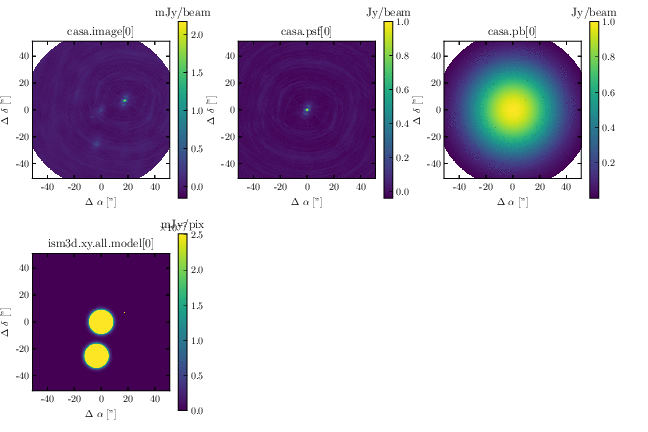

In [83]:
units=[] ; images=[] ; titles=[]; vmaxs=[]; vmins=[]

for version in ['casa.image','casa.psf','casa.pb','ism3d.xy.all.model']:
    if version is not None:
        data,hdr=fits.getdata(model_name+'_arts.images/'+version+'.fits',header=True)
        titles.append(version)
        if '.psf' in titles[-1] or '.pb' in titles[-1]:
            images.append(data); units.append("Jy/beam")
        elif 'model' in titles[-1]:
            images.append(data*1e3); units.append("mJy/pix")
        else:
            images.append(data*1e3); units.append("mJy/beam")
        p=np.nanpercentile(images[-1],[0,25,95,100])
        if '.model' in titles[-1]:    
            vmins.append(p[0])
            vmaxs.append(p[2])
        else:
            vmins.append(p[0])
            vmaxs.append(p[3])
    else:
        titles.append(None);  images.append(None); units.append(None); vmaxs.append(None); vmins.append(None)

w = WCS(hdr).celestial
coord = SkyCoord(hdr['CRVAL1'], hdr['CRVAL2'], unit="deg")
offset_w=linear_offset_coords(w,coord)
nchan=hdr['NAXIS3']
stepchan= int(np.maximum(np.floor(int(nchan/5)),1))

fignames=[]
for ichan in range(0,nchan,stepchan):
    
    #clear_output(wait=True)
    figname=model_name+'_arts.images/chmap/ch{:03d}'.format(ichan)+'.pdf'
    images0=[None if image is None else image[ichan,:,:] for image in images]
    titles0=[None if title is None else title+'['+'{}'.format(ichan)+']' for title in titles ]
    im_grid(images0,offset_w,units=units,titles=titles0,nxy=(3,2),figsize=(9,6),figname=figname,vmins=vmins,vmaxs=vmaxs) ;
    fignames.append(figname) 

make_gif(fignames,model_name+'_arts.images/chmap.gif')
show_gif(model_name+'_arts.images/chmap.gif')